## PG_modeling_LR_SVM_x-validation.ipynb

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, multilabel_confusion_matrix
from sklearn.metrics import auc, roc_curve,roc_auc_score, recall_score, precision_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import scale, label_binarize

In [2]:
import pandas as pd  # provides interface for interacting with tabular data
import geopandas as gpd  # combines the capabilities of pandas and shapely for geospatial operations
from shapely.geometry import Point, Polygon, MultiPolygon  # for manipulating text data into geospatial shapes
from shapely import wkt  # stands for "well known text," allows for interchange across GIS programs
import rtree  # supports geospatial join
import os
import fnmatch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import descartes
import sys
import sklearn
from shapely.ops import nearest_points
from datetime import datetime as dt, date
sys.path.append('/Users/pedrogalarza/Documents/NYU-MSDS/2020_fall/DSGA-1001/Project-Wildfire/wildfires-1001/code/functions')
from gis_processing import *
import pickle

## Data Import
### county grid

In [3]:
project_dir = '/Users/pedrogalarza/Documents/NYU-MSDS/2020_fall/DSGA-1001/Project-Wildfire/wildfires-1001/'
data_dir = os.path.join(project_dir, "data")

### Target/Feature DF

In [4]:
weather_rename_dict = pd.read_pickle(os.path.join(data_dir, 'clean_data/ERA_weather-data/ERA_rename_dictionary.pkl'))


target_df1 = pd.read_pickle(os.path.join(data_dir, 'clean_data/target_df_final_1123_newtargets_1.pkl'))
target_df2 = pd.read_pickle(os.path.join(data_dir, 'clean_data/target_df_final_1123_newtargets_2.pkl'))
target_df = target_df1.append(target_df2)
target_df.rename(columns = weather_rename_dict, inplace = True)
target_df.describe()

,GRID_ID,MONTH,COUNTYFP,GRID_AREA,Y_bin,Y_fire_count,Fire_area,elev_mean,elev_std,elev_media,...,tot_prcp_0hrs_10y,tot_prcp_6hrs_10y,tot_prcp_12hrs_10y,tot_prcp_18hrs_10y,Y_bin_new_fire_month,Y_count_new_fires_month,Y_max_new_fire_size_month,YEAR,Y_fire_class_size,Y_fire_area_prop
count,47388.000000,47388.00000,47388.000000,4.738800e+04,47388.000000,47388.000000,4.738800e+04,47388.000000,47388.000000,47388.000000,...,47388.000000,4.738800e+04,4.738800e+04,47388.000000,47388.000000,47388.00000,47388.000000,47388.000000,47388.000000,47388.000000
mean,74.113636,6.51532,56.045455,4.464008e+09,0.107559,0.183253,3.784069e+06,3140.474471,1084.974280,3076.439394,...,0.001687,4.048486e-04,7.989659e-04,0.001199,0.084979,11.21727,0.154448,2004.540390,0.227146,0.000797
std,43.075380,3.44465,30.868045,1.196134e+09,0.309826,0.748612,4.243673e+07,2372.252254,570.638010,2406.024874,...,0.001923,4.762958e-04,9.606580e-04,0.001435,0.278854,13.67637,0.562219,8.633634,0.750644,0.008979
min,0.000000,1.00000,1.000000,8.817689e+08,0.000000,0.000000,0.000000e+00,36.480644,49.813656,10.000000,...,0.000002,3.538056e-09,7.044763e-07,0.000002,0.000000,0.00000,0.000000,1990.000000,0.000000,0.000000
25%,36.750000,4.00000,29.000000,4.925484e+09,0.000000,0.000000,0.000000e+00,1089.717375,647.602436,1155.000000,...,0.000295,5.701410e-05,1.031866e-04,0.000160,0.000000,1.00000,0.000000,1997.000000,0.000000,0.000000
50%,72.500000,7.00000,52.000000,5.041000e+09,0.000000,0.000000,0.000000e+00,2639.686730,932.013432,2580.000000,...,0.000937,2.173830e-04,4.107332e-04,0.000616,0.000000,6.00000,0.000000,2005.000000,0.000000,0.000000
75%,112.250000,10.00000,83.000000,5.041000e+09,0.000000,0.000000,0.000000e+00,4523.851772,1409.343560,4320.000000,...,0.002409,5.889937e-04,1.148286e-03,0.001721,0.000000,15.00000,0.000000,2012.000000,0.000000,0.000000
max,147.000000,12.00000,111.000000,5.041000e+09,1.000000,31.000000,1.651920e+09,10172.821400,3316.579812,10920.000000,...,0.013519,3.452437e-03,6.903017e-03,0.010235,1.000000,66.00000,3.000000,2019.000000,4.000000,0.327697


#### Feature Lists

In [5]:
RF_entropy_top30_features = pd.read_pickle(os.path.join(project_dir, 'models/feature_lists/RF_entropy_top30_features.pkl'))
RF_gini_top20_features = pd.read_pickle(os.path.join(project_dir, 'models/feature_lists/RF_gini_top20_features.pkl'))

In [6]:
non_mod_cols = ['GRID_ID','month_id','COUNTYFP','COUNTY_AREA', 'NAME','GRID_AREA','COUNTY_ARE','month_id_old_x','month_id_old_y',
                'geometry','Fire_area','total_fire_days','hist_p_time_1y','total_fire_days','hist_p_time_1y', 
                'hist_p_time_1m', 'month_id_old', 'YEAR', 'adj_fire_count']
Y_cols = ['Y_bin', 'Y_fire_count', 'Y_fire_area_prop', 'Y_fire_class_size','Y_bin_new_fire_month',
          'Y_max_new_fire_size_month','Y_count_new_fires_month']
        
target_df_working = target_df

## Train- test Split

#### select feature and normalize

In [8]:
target_model_df=target_df
target_feat = "Y_bin_new_fire_month"
feature_filter = RF_gini_top20_features

target_model_df[feature_filter] = pd.DataFrame(scale(target_model_df[feature_filter]), columns = feature_filter)
full_time_series_df = target_model_df[["YEAR"] + ["MONTH"] + [target_feat] + feature_filter]
full_time_series_df.describe()

,YEAR,MONTH,Y_bin_new_fire_month,hist_prop_area_fire_1m,2m_tmp_18hrs_5y,tot_area_fire_prev_1yr,tot_prcp_6hrs_5y,adj_fire_bcount,U_wind_10m_18hrs,tot_prcp_18hrs,...,hist_bin_no_leak_1m,U_wind_10m_12hrs_1y,V_wind_10m_18hrs_5y,V_wind_10m_12hrs_5y,hist_cl_size_1y,Total Arsons,hist_cl_size_10y,leaf_high_veg_6hrs_5y,leaf_low_veg_12hrs,leaf_low_veg_6hrs
count,47388.000000,47388.00000,47388.000000,4.738800e+04,4.738800e+04,4.738800e+04,4.738800e+04,4.738800e+04,4.738800e+04,4.738800e+04,...,4.738800e+04,4.738800e+04,4.738800e+04,4.738800e+04,4.738800e+04,4.738800e+04,4.738800e+04,4.738800e+04,4.738800e+04,4.738800e+04
mean,2004.540390,6.51532,0.084979,1.483597e-14,-8.486829e-16,1.349917e-15,1.796810e-15,7.589289e-16,8.153537e-17,8.354927e-16,...,-1.014321e-14,-8.370343e-16,-5.846262e-16,6.759063e-16,2.087790e-15,1.651697e-15,1.222104e-14,-3.350508e-15,-4.193207e-17,-4.193207e-17
std,8.633634,3.44465,0.278854,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,...,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00
min,1990.000000,1.00000,0.000000,-8.877704e-02,-2.790997e+00,-2.215626e-01,-8.004240e-01,-6.119647e-01,-2.825473e+00,-6.161681e-01,...,-3.096434e-01,-2.527266e+00,-6.157983e+00,-7.119955e+00,-8.006606e-01,-3.678876e-01,-1.629448e+00,-1.888961e+00,-1.866327e+00,-1.866327e+00
25%,1997.000000,4.00000,0.000000,-8.877704e-02,-7.112080e-01,-2.215626e-01,-7.027341e-01,-6.119647e-01,-6.717508e-01,-5.894270e-01,...,-3.096434e-01,-6.705478e-01,-5.817662e-01,-4.891314e-01,-8.006606e-01,-3.616732e-01,-1.012379e+00,-3.765754e-01,-9.931556e-01,-9.931556e-01
50%,2005.000000,7.00000,0.000000,-8.877704e-02,-1.591251e-02,-2.215626e-01,-3.932606e-01,-6.119647e-01,-1.553028e-01,-4.186424e-01,...,-3.096434e-01,-8.347792e-02,1.549976e-02,8.030444e-02,-8.006606e-01,-3.109226e-01,2.217582e-01,6.974831e-02,-5.443763e-02,-5.443763e-02
75%,2012.000000,10.00000,0.000000,-8.877704e-02,7.768389e-01,-1.913890e-01,3.422281e-01,3.012417e-01,5.249218e-01,1.392299e-01,...,-3.096434e-01,5.634163e-01,6.693304e-01,6.031621e-01,6.241124e-01,3.811719e-02,8.388269e-01,6.963938e-01,7.894266e-01,7.894266e-01
max,2019.000000,12.00000,1.000000,3.640843e+01,2.407328e+00,1.713725e+01,7.510055e+00,4.867274e+00,6.897779e+00,9.928960e+00,...,3.229522e+00,7.179029e+00,3.078054e+00,2.707416e+00,2.048885e+00,9.906518e+00,8.388269e-01,2.204154e+00,2.392823e+00,2.392823e+00


## Split data into train and test sets

In [9]:
train_data = full_time_series_df[(target_model_df['YEAR']>=1990) & (target_model_df['YEAR']<=2020)]
test_data = full_time_series_df[target_model_df['YEAR']>2016]
train_data.describe()

,YEAR,MONTH,Y_bin_new_fire_month,hist_prop_area_fire_1m,2m_tmp_18hrs_5y,tot_area_fire_prev_1yr,tot_prcp_6hrs_5y,adj_fire_bcount,U_wind_10m_18hrs,tot_prcp_18hrs,...,hist_bin_no_leak_1m,U_wind_10m_12hrs_1y,V_wind_10m_18hrs_5y,V_wind_10m_12hrs_5y,hist_cl_size_1y,Total Arsons,hist_cl_size_10y,leaf_high_veg_6hrs_5y,leaf_low_veg_12hrs,leaf_low_veg_6hrs
count,47388.000000,47388.00000,47388.000000,4.738800e+04,4.738800e+04,4.738800e+04,4.738800e+04,4.738800e+04,4.738800e+04,4.738800e+04,...,4.738800e+04,4.738800e+04,4.738800e+04,4.738800e+04,4.738800e+04,4.738800e+04,4.738800e+04,4.738800e+04,4.738800e+04,4.738800e+04
mean,2004.540390,6.51532,0.084979,1.483597e-14,-8.486829e-16,1.349917e-15,1.796810e-15,7.589289e-16,8.153537e-17,8.354927e-16,...,-1.014321e-14,-8.370343e-16,-5.846262e-16,6.759063e-16,2.087790e-15,1.651697e-15,1.222104e-14,-3.350508e-15,-4.193207e-17,-4.193207e-17
std,8.633634,3.44465,0.278854,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,...,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00
min,1990.000000,1.00000,0.000000,-8.877704e-02,-2.790997e+00,-2.215626e-01,-8.004240e-01,-6.119647e-01,-2.825473e+00,-6.161681e-01,...,-3.096434e-01,-2.527266e+00,-6.157983e+00,-7.119955e+00,-8.006606e-01,-3.678876e-01,-1.629448e+00,-1.888961e+00,-1.866327e+00,-1.866327e+00
25%,1997.000000,4.00000,0.000000,-8.877704e-02,-7.112080e-01,-2.215626e-01,-7.027341e-01,-6.119647e-01,-6.717508e-01,-5.894270e-01,...,-3.096434e-01,-6.705478e-01,-5.817662e-01,-4.891314e-01,-8.006606e-01,-3.616732e-01,-1.012379e+00,-3.765754e-01,-9.931556e-01,-9.931556e-01
50%,2005.000000,7.00000,0.000000,-8.877704e-02,-1.591251e-02,-2.215626e-01,-3.932606e-01,-6.119647e-01,-1.553028e-01,-4.186424e-01,...,-3.096434e-01,-8.347792e-02,1.549976e-02,8.030444e-02,-8.006606e-01,-3.109226e-01,2.217582e-01,6.974831e-02,-5.443763e-02,-5.443763e-02
75%,2012.000000,10.00000,0.000000,-8.877704e-02,7.768389e-01,-1.913890e-01,3.422281e-01,3.012417e-01,5.249218e-01,1.392299e-01,...,-3.096434e-01,5.634163e-01,6.693304e-01,6.031621e-01,6.241124e-01,3.811719e-02,8.388269e-01,6.963938e-01,7.894266e-01,7.894266e-01
max,2019.000000,12.00000,1.000000,3.640843e+01,2.407328e+00,1.713725e+01,7.510055e+00,4.867274e+00,6.897779e+00,9.928960e+00,...,3.229522e+00,7.179029e+00,3.078054e+00,2.707416e+00,2.048885e+00,9.906518e+00,8.388269e-01,2.204154e+00,2.392823e+00,2.392823e+00


#### Build Cross Validation Splits: LR, Rolling Origin

In [10]:
def xVal_time_series_rolling_LR(dataset, label_name,k,cs):
    years_unique = dataset.YEAR.unique()
    years_len = len(years_unique)
    interval_len = int(years_len/k)
    
    k_fold_list = []
    for i in range(years_len):
        k_fold_list.append(years_unique[interval_len*i:interval_len*i+interval_len])
        k_fold_list = k_fold_list[:k]
        
        
    AUC_dict = {}
    recall_dict = {}
    precision_dict = {}

    
    for i in range(1,k):
        train_fold = train_data[train_data["YEAR"].isin(np.ravel(k_fold_list[:i]))].drop(["YEAR","MONTH"],axis=1)
        validation_fold = train_data[train_data["YEAR"].isin(np.ravel(k_fold_list[i]))].drop(["YEAR","MONTH"],axis=1)
        
        for c in cs:
            LR_ts_kfold = LogisticRegression(C = c, class_weight = 'balanced').fit(train_fold.drop(label_name, 1),train_fold[label_name])
            AUC_search = roc_auc_score(validation_fold[label_name], LR_ts_kfold.predict_proba(validation_fold.drop(label_name,1))[:,1])
            recall_search = recall_score(validation_fold[label_name], LR_ts_kfold.predict(validation_fold.drop(label_name,1)))
            precision_search = precision_score(validation_fold[label_name], LR_ts_kfold.predict(validation_fold.drop(label_name,1)))

            
            if c in AUC_dict:
                AUC_dict[c].append(AUC_search)
            else:
                AUC_dict[c] = [AUC_search]
            if c in recall_dict:
                recall_dict[c].append(recall_search)
            else:
                recall_dict[c] = [recall_search]
            if c in precision_dict:
                precision_dict[c].append(precision_search)
            else:
                precision_dict[c] = [precision_search]
            
        
    return(pd.DataFrame(AUC_dict),pd.DataFrame(recall_dict),pd.DataFrame(precision_dict))

#### Build Cross Validation Splits: LR, Sliding Window

In [11]:
def xVal_time_series_sliding_LR(dataset, label_name,k,cs):
    years_unique = dataset.YEAR.unique()
    years_len = len(years_unique)
    interval_len = int(years_len/k)
    
    k_fold_list = []
    for i in range(years_len):
        k_fold_list.append(years_unique[interval_len*i:interval_len*i+interval_len])
        k_fold_list = k_fold_list[:k]
        
        
    AUC_dict = {}
    recall_dict = {}
    precision_dict = {}
    
    for i in range(1,k):
        train_fold = train_data[train_data["YEAR"].isin(np.ravel(k_fold_list[i]))].drop(["YEAR","MONTH"],axis=1)
        validation_fold = train_data[train_data["YEAR"].isin(np.ravel(k_fold_list[i]))].drop(["YEAR","MONTH"],axis=1)
        
        for c in cs:
            LR_ts_kfold = LogisticRegression(C = c, class_weight = 'balanced').fit(train_fold.drop(label_name, 1),train_fold[label_name])
            AUC_search = roc_auc_score(validation_fold[label_name], LR_ts_kfold.predict_proba(validation_fold.drop(label_name,1))[:,1])
            recall_search = recall_score(validation_fold[label_name], LR_ts_kfold.predict(validation_fold.drop(label_name,1)))
            precision_search = precision_score(validation_fold[label_name], LR_ts_kfold.predict(validation_fold.drop(label_name,1)))

            
            if c in AUC_dict:
                AUC_dict[c].append(AUC_search)
            else:
                AUC_dict[c] = [AUC_search]
            if c in recall_dict:
                recall_dict[c].append(recall_search)
            else:
                recall_dict[c] = [recall_search]
            if c in precision_dict:
                precision_dict[c].append(precision_search)
            else:
                precision_dict[c] = [precision_search]
            
        
    return(pd.DataFrame(AUC_dict),pd.DataFrame(recall_dict),pd.DataFrame(precision_dict))

#### Cross Validation Comparison

In [14]:
cs = [10**i for i in range(-8, 2)]
rolling_xVal_LR = xVal_time_series_rolling_LR(train_data, "Y_bin_new_fire_month",9,cs)
sliding_xVal_LR = xVal_time_series_sliding_LR(train_data, "Y_bin_new_fire_month",9,cs)

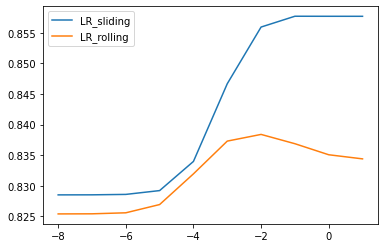

In [15]:
plt.plot(range(-8, 2),sliding_xVal_LR[0].mean(),label="LR_sliding")
plt.plot(range(-8, 2),rolling_xVal_LR[0].mean(),label = "LR_rolling")
plt.legend()

### SVM

In [16]:
def xVal_time_series_rolling_SVM(dataset, label_name,k,cs):
    years_unique = dataset.YEAR.unique()
    years_len = len(years_unique)
    interval_len = int(years_len/k)
    
    k_fold_list = []
    for i in range(years_len):
        k_fold_list.append(years_unique[interval_len*i:interval_len*i+interval_len])
        k_fold_list = k_fold_list[:k]
        
        
#     linSVC_score_dict = {}
#     linSVC_preds_dict = {}
    AUC_dict = {}

    
    for i in range(1,k):
        train_fold = train_data[train_data["YEAR"].isin(np.ravel(k_fold_list[:i]))].drop(["YEAR","MONTH"],axis=1)
        validation_fold = train_data[train_data["YEAR"].isin(np.ravel(k_fold_list[i]))].drop(["YEAR","MONTH"],axis=1)
        
        for c in cs:
            model_ts_kfold = LinearSVC(C = c, class_weight = 'balanced', dual = False).fit(train_fold.drop(label_name, 1),train_fold[label_name])
#             AUC_search = roc_auc_score(validation_fold[label_name], model_ts_kfold.predict_proba(validation_fold.drop(label_name,1))[:,1])
#             recall_search = recall_score(validation_fold[label_name], model_ts_kfold.predict(validation_fold.drop(label_name,1)))
            linSVC_score = model_ts_kfold.decision_function(validation_fold.drop(label_name,1))
            linSVC_preds = model_ts_kfold.predict(validation_fold.drop(label_name,1))
            fpr, tpr, thresholds = roc_curve(validation_fold[label_name], linSVC_score)

            
            if c in AUC_dict:
                AUC_dict[c].append(auc(fpr, tpr))
            else:
                AUC_dict[c] = [auc(fpr, tpr)]
#             if c in recall_dict:
#                 recall_dict[c].append(recall_search)
#             else:
#                 recall_dict[c] = [recall_search]
#             if c in precision_dict:
#                 precision_dict[c].append(precision_search)
#             else:
#                 precision_dict[c] = [precision_search]
            
        
    return(pd.DataFrame(AUC_dict))#,pd.DataFrame(recall_dict),pd.DataFrame(precision_dict))

In [17]:
def xVal_time_series_sliding_SVM(dataset, label_name,k,cs):
    years_unique = dataset.YEAR.unique()
    years_len = len(years_unique)
    interval_len = int(years_len/k)
    
    k_fold_list = []
    for i in range(years_len):
        k_fold_list.append(years_unique[interval_len*i:interval_len*i+interval_len])
        k_fold_list = k_fold_list[:k]
        
        
#     linSVC_score_dict = {}
#     linSVC_preds_dict = {}
    AUC_dict = {}

    
    for i in range(1,k):
        train_fold = train_data[train_data["YEAR"].isin(np.ravel(k_fold_list[i]))].drop(["YEAR","MONTH"],axis=1)
        validation_fold = train_data[train_data["YEAR"].isin(np.ravel(k_fold_list[i]))].drop(["YEAR","MONTH"],axis=1)
        
        for c in cs:
            model_ts_kfold = LinearSVC(C = c, class_weight = 'balanced', dual = False).fit(train_fold.drop(label_name, 1),train_fold[label_name])
#             AUC_search = roc_auc_score(validation_fold[label_name], model_ts_kfold.predict_proba(validation_fold.drop(label_name,1))[:,1])
#             recall_search = recall_score(validation_fold[label_name], model_ts_kfold.predict(validation_fold.drop(label_name,1)))
            linSVC_score = model_ts_kfold.decision_function(validation_fold.drop(label_name,1))
            linSVC_preds = model_ts_kfold.predict(validation_fold.drop(label_name,1))
            fpr, tpr, thresholds = roc_curve(validation_fold[label_name], linSVC_score)

            
            if c in AUC_dict:
                AUC_dict[c].append(auc(fpr, tpr))
            else:
                AUC_dict[c] = [auc(fpr, tpr)]
#             if c in recall_dict:
#                 recall_dict[c].append(recall_search)
#             else:
#                 recall_dict[c] = [recall_search]
#             if c in precision_dict:
#                 precision_dict[c].append(precision_search)
#             else:
#                 precision_dict[c] = [precision_search]
            
        
    return(pd.DataFrame(AUC_dict))#,pd.DataFrame(recall_dict),pd.DataFrame(precision_dict))

In [18]:
cs = [10**i for i in range(-8, 2)]
rolling_xVal_SVM = xVal_time_series_rolling_SVM(train_data, "Y_bin_new_fire_month",9,cs)
sliding_xVal_SVM = xVal_time_series_sliding_SVM(train_data, "Y_bin_new_fire_month",9,cs)

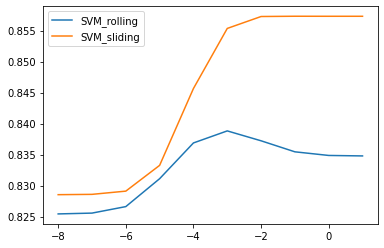

In [19]:
plt.plot(range(-8, 2),rolling_xVal_SVM.mean(),label = "SVM_rolling")
plt.plot(range(-8, 2),sliding_xVal_SVM.mean(),label = "SVM_sliding")
plt.legend()

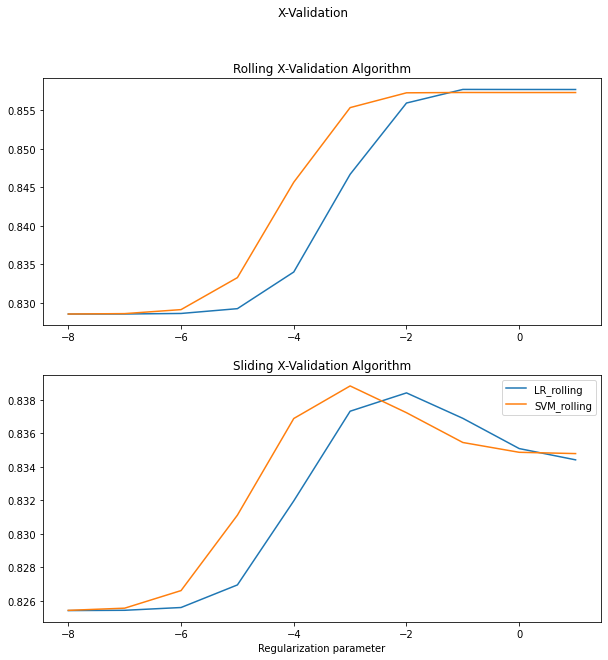

In [20]:
fig,ax = plt.subplots(2,1,figsize=(10,10))
fig.suptitle("X-Validation")

ax[0].plot(range(-8, 2),sliding_xVal_LR[0].mean(),label="LR_sliding")
ax[0].plot(range(-8, 2),sliding_xVal_SVM.mean(),label = "SVM_sliding")
ax[0].set_title("Rolling X-Validation Algorithm")
ax[1].plot(range(-8, 2),rolling_xVal_LR[0].mean(),label = "LR_rolling")
ax[1].plot(range(-8, 2),rolling_xVal_SVM.mean(),label = "SVM_rolling")
ax[1].set_title("Sliding X-Validation Algorithm")
ax[1].set_xlabel("Regularization parameter")

plt.legend()
plt.show()